In [1]:
import os
import gc
import sys
import pdb
import copy
import glob
import psutil
import imageio
import calendar
import importlib
import numpy as np
import xarray as xr
import cmasher as cmr
import matplotlib as mpl
import matplotlib.gridspec
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.ticker as ticker
import matplotlib.patches as patches
from memory_profiler import memory_usage
from matplotlib.patches import Rectangle
from cftime import DatetimeNoLeap as date
from matplotlib.colors import TwoSlopeNorm
from matplotlib.dates import DateFormatter
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import LinearSegmentedColormap

plt.rcParams.update({
    'font.size'       : 14,   # Base font size
    'axes.labelsize'  : 14,   # Axis labels
    'xtick.labelsize' : 12,   # X-axis tick labels
    'ytick.labelsize' : 12,   # Y-axis tick labels
    'legend.fontsize' : 12,   # Legend font size
    'figure.titlesize': 16    # Figure title size
})
plt.ioff()
#mpl.use('Agg')
#%matplotlib agg

sys.path.insert(1, '/global/homes/j/jhollo/repos/climate_analysis/CLDERA/TEM/limvar_analysis_NERSC')
import plotting_utils as putil
import compute_ensemble_stats as ces
importlib.reload(putil)
importlib.reload(ces)
fix_dtint   = putil.adjust_10daily_integrated_tendency
shift_dtint = putil.shift_integrated_tendency
sig         = putil.filter_significance
cmn         = putil.get_cmap_norm

sys.path.insert(1, '/global/homes/j/jhollo/repos/climate_analysis/CLDERA/wavePaperFigs/util')
import nclcmaps as ncm

In [2]:
importlib.reload(putil)
importlib.reload(ces)
from IPython.display import clear_output

# ----- get data
kwargs = {'freq':'monthly', 'return_intersection':False, 'return_members':False, 'skip_nosrctag':False}
#kwargs = {'freq':'10daily', 'return_intersection':True, 'return_members':False, 'skip_nosrctag':False}
monthly = kwargs['freq'] == 'monthly'
u_           = putil.get_variable('U', **kwargs)
utendepfd_   = putil.get_variable('utendepfd', **kwargs)
utendresvel_ = putil.get_variable('utendresvel', **kwargs)
if(monthly):
    utendgw_     = putil.get_variable('utendgw', **kwargs)
utenddiff_   = putil.get_variable('utenddiff', **kwargs)
clear_output()

In [3]:
importlib.reload(putil)
importlib.reload(ces)

spm = 30*24*60*60 # seconds per month

# ----- extract counterfactual ensemble mean and members
u           = u_['cfmean']
utendepfd   = utendepfd_['cfmean'] * spm
utendresvel = utendresvel_['cfmean'] * spm
utenddiff   = utenddiff_['cfmean'] * spm
if(monthly):
    utenddiff   = -utenddiff
    utendgw     = utendgw_['cfmean'] * spm
    utend       = utendepfd + utendresvel + utendgw + utenddiff
else:
    utend       = utendepfd + utendresvel + utenddiff
utend.name  = 'utend'

# ----- combine data, make month coordinate
if(monthly):
    allvars = [u, utendepfd, utendresvel, utendgw, utenddiff, utend]
else:
    allvars = [u, utendepfd, utendresvel, utenddiff, utend]
cf = xr.merge(allvars)

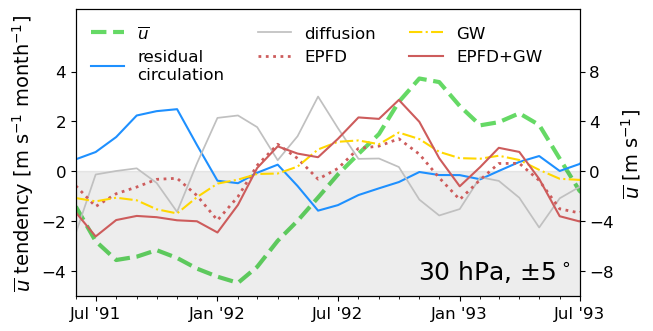

In [4]:
importlib.reload(putil)
importlib.reload(ces)

# --- make figure
fig = plt.figure(figsize=(6.5,3.73))
ax = fig.add_subplot(111)
ax2 = ax.twinx()
ax2.set_zorder(0)
ax.set_zorder(1)
ax.patch.set_visible(False)

# ---- get dims and data
latb = 5
plev = cf.plev
time = putil.to_datetime(cf.time)
cf_trop     = cf.sel(plev=30, method='nearest').sel(lat=slice(-latb,latb)).mean('lat')

# ----- plotting settings
topt = {'option':'solstice', 'include_year':True, 'year_delimiter':' '}
ulev = np.arange(-12, 7.6, 1.5)
ucmap = 'RdBu_r'
ylim = [7, 150]
tlim = [datetime(1991,6,1),datetime(1993,7,1)]
utcolor   = 'k'  #  color for utend
utepcolor = 'indianred'  #  color for utendepfd
utrvcolor = 'dodgerblue'  #  color for utendresvel
utgwcolor  = 'gold'  #  color for utendgw
utdcolor  = 'silver'  #  color for utenddiff
tlw = 1.5 # linewidth for tendencies 

# --- plot TEM balance at 30 hPa
ax.plot([], [], '--', lw=tlw*2, color='limegreen', alpha=0.75, label='$\\overline{u}$')
ax2.plot(time, cf_trop['U'], '--', lw=tlw*2, color='limegreen', alpha=0.75)
# plot tendencies
ax.plot(time, cf_trop['utendresvel'], lw=tlw, color=utrvcolor, label='residual\ncirculation')
if(monthly):
    ax.plot(time, cf_trop['utenddiff'], '-', lw=tlw/1.2, color=utdcolor, label='diffusion')
    ax.plot(time, cf_trop['utendepfd'], ':', lw=tlw*1.33, color=utepcolor, label='EPFD')
    ax.plot(time, cf_trop['utendgw'], '-.', lw=tlw*1, color=utgwcolor, label='GW')
    ax.plot(time, cf_trop['utendepfd']+cf_trop['utendgw'], lw=tlw, color=utepcolor, label='EPFD+GW')
else:
    ax.plot(time, cf_trop['utendepfd'], lw=tlw, color=utepcolor, label='EPFD')
    ax.plot(time, cf_trop['utenddiff'], lw=tlw, color=utdcolor, label='parameterized')
#ax.plot(time, cf_trop['utend'], lw=tlw, color=utcolor)

ax.set_ylim(-5, 6.5)
ax.yaxis.set_ticks([-4, -2, 0, 2, 4])
ax2.set_ylim(-10, 13)
ax2.yaxis.set_ticks([-8, -4, 0, 4, 8])

# --- shade negative region
ylim = ax.get_ylim()
ax.fill_between(time, y1=np.zeros(len(time)), y2=np.ones(len(time))*ylim[0], color='k', alpha=0.07)
ax.set_ylim(ylim)
ax.set_xlim(tlim)

# --- legend
ax.legend(loc='upper left', ncol=3, frameon=False, fontsize=12)

# --- format
#ax.yaxis.set_ticks(np.arange(round(int(ylim[0]),-1), round(int(ylim[1]), -1), 2))
putil.season_timeticks(ax, time, **topt)
ax.set_ylabel('$\\overline{u}$ tendency [m s$^{-1}$ month$^{-1}$]')
ax2.set_ylabel('$\\overline{u}$ [m s$^{-1}$]')
ax.annotate('30 hPa, $\\pm$5$^\\circ$', xy=(0.68, 0.06), xycoords="axes fraction", fontsize=18)#, weight = 'bold')

plt.savefig('figs/qbo_tem_balance.pdf', dpi=250, bbox_inches='tight')
plt.show()